##### Importing libraries and framework

In [15]:
# Importing the necessary libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import plot_tree
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### Prepare the data  (able to reuse the code from linear_regression.ipynb)

In [8]:
# Load the data from the CSV file into a DataFrame
data = pd.read_csv('datasets/listings_preprocessed.csv')

# Separate the input features (X) and target variable (y)
X = data.drop('price', axis=1)
y = data['price']

# Filter out non-numeric columns
numeric_columns = X.select_dtypes(include=['number']).columns
X_numeric = X[numeric_columns]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.2, random_state=42)

# One-hot encode categorical features
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

# Align the columns of the training and testing sets
X_train, X_test = X_train.align(X_test, join='left', axis=1)

# Fill missing values in the training set with the mean of each column
X_train.fillna(X_train.mean(), inplace=True)

# Fill missing values in the test set with the mean of the corresponding columns in the training set
X_test.fillna(X_train.mean(), inplace=True)

# Fill remaining NaN values with 0
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

#### Filter and extract only top 5 variables to be used to predict the price (able to reuse the code from linear_regression.ipynb)

In [9]:
def select_top_k_abs_correlated(X_train, y_train, X_test, k):
    # Calculate the correlation matrix between features and the target variable
    corr_matrix = X_train.corrwith(y_train)

    # Compute the absolute correlation values
    abs_corr_matrix = corr_matrix.abs()

    # Select the top k variables with the highest absolute correlation values
    top_k_abs_correlated = abs_corr_matrix.sort_values(ascending=False)[:k]

    # Print the top k variables
    print(f"Top {k} variables with the highest absolute correlation values:\n", top_k_abs_correlated)

    # Filter the original training and testing sets to include only the top k variables with the highest absolute correlation values
    X_train_selected = X_train[top_k_abs_correlated.index]
    X_test_selected = X_test[top_k_abs_correlated.index]

    return X_train_selected, X_test_selected, top_k_abs_correlated

X_train_selected, X_test_selected, top_k_abs_correlated = select_top_k_abs_correlated(X_train, y_train, X_test, k=5)

Top 5 variables with the highest absolute correlation values:
 room_type_Private room                         0.442091
bedrooms                                       0.425693
calculated_host_listings_count_entire_homes    0.410485
property_type_Private room in rental unit      0.400065
minimum_nights                                 0.389756
dtype: float64


#### Create the model, predict the data and display the performance metrics

In [13]:
def train_random_forest(X_train_selected, y_train, X_test_selected, y_test, n_estimators=100, random_state=42):
    # Create a random forest regression model
    rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state)

    # Train the model using the training data with the selected features
    rf_model.fit(X_train_selected, y_train)

    # Make predictions using the test data and the selected features
    y_pred_rf = rf_model.predict(X_test_selected)

    # Calculate the mean squared error and R^2 score for the predictions
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)

    # Print the results
    print("Performance metrics")
    print("Random Forest - Mean squared error:", mse_rf)
    print("Random Forest - R^2 score:", r2_rf)

    return rf_model, y_pred_rf

# Call the function with the appropriate arguments
trained_rf_model, y_pred_rf = train_random_forest(X_train_selected, y_train, X_test_selected, y_test, n_estimators=100, random_state=42)

Performance metrics
Random Forest - Mean squared error: 6756.653989068562
Random Forest - R^2 score: 0.5901432935680248


#### In random forest models, there are no coefficients like in linear regression models. Random forests are ensembles of decision trees, and each decision tree uses a hierarchical structure to make decisions based on feature values rather than using coefficients to represent the relationship between the features and the target variable.

#### However, I can still analyze the feature importances, as shown in the previous response, to understand how much each feature contributes to the model's predictions. Feature importances represent the importance of each feature in making predictions in the random forest model. The higher the importance, the more the feature contributes to the model's decision-making process.

In [11]:
def print_rf_sorted_feature_importances(top_k_correlated, rf_model):
    # Get the feature importances from the random forest model
    rf_feature_importances = rf_model.feature_importances_

    # Pair feature names with their importances and sort in descending order
    sorted_rf_importances = sorted(zip(top_k_correlated.index, rf_feature_importances), key=lambda x: x[1], reverse=True)

    # Print the sorted feature importances
    print("Feature importance")
    for feature, importance in sorted_rf_importances:
        print(f"{feature}: {importance:.4f}")

print_rf_sorted_feature_importances(top_k_abs_correlated, trained_rf_model)

Feature importance
calculated_host_listings_count_entire_homes: 0.5329
minimum_nights: 0.2029
bedrooms: 0.1914
room_type_Private room: 0.0472
property_type_Private room in rental unit: 0.0256


#### To visualize the performance of the random forest regression model, you can create a scatter plot of the true prices (y_test) against the predicted prices (y_pred), similar to the linear regression model:

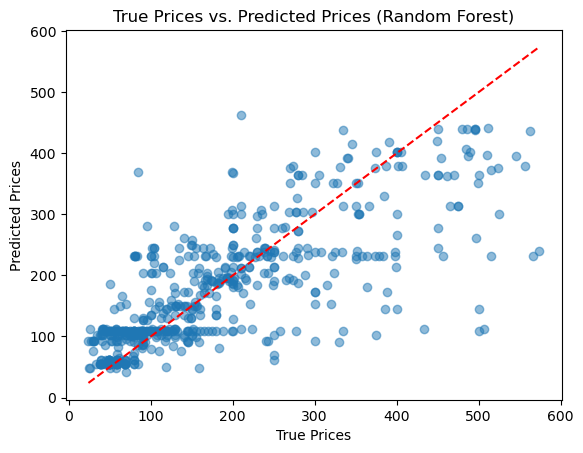

In [14]:
def plot_true_vs_predicted_rf(y_test, y_pred_rf):
    # Create a scatter plot of true vs. predicted prices
    plt.scatter(y_test, y_pred_rf, alpha=0.5)
    plt.xlabel("True Prices")
    plt.ylabel("Predicted Prices")
    plt.title("True Prices vs. Predicted Prices (Random Forest)")

    # Add a diagonal line to represent a perfect fit
    min_val = min(min(y_test), min(y_pred_rf))
    max_val = max(max(y_test), max(y_pred_rf))
    plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

    plt.show()

plot_true_vs_predicted_rf(y_test, y_pred_rf)

#### Plot the random forest regression model

#### Plotting the entire random forest model is not feasible, as it consists of multiple decision trees. However, it can be visualized individual decision trees within the random forest to get an idea of the structure of the trees used in the model. Keep in mind that this will only represent one tree from the ensemble and not the whole random forest model.

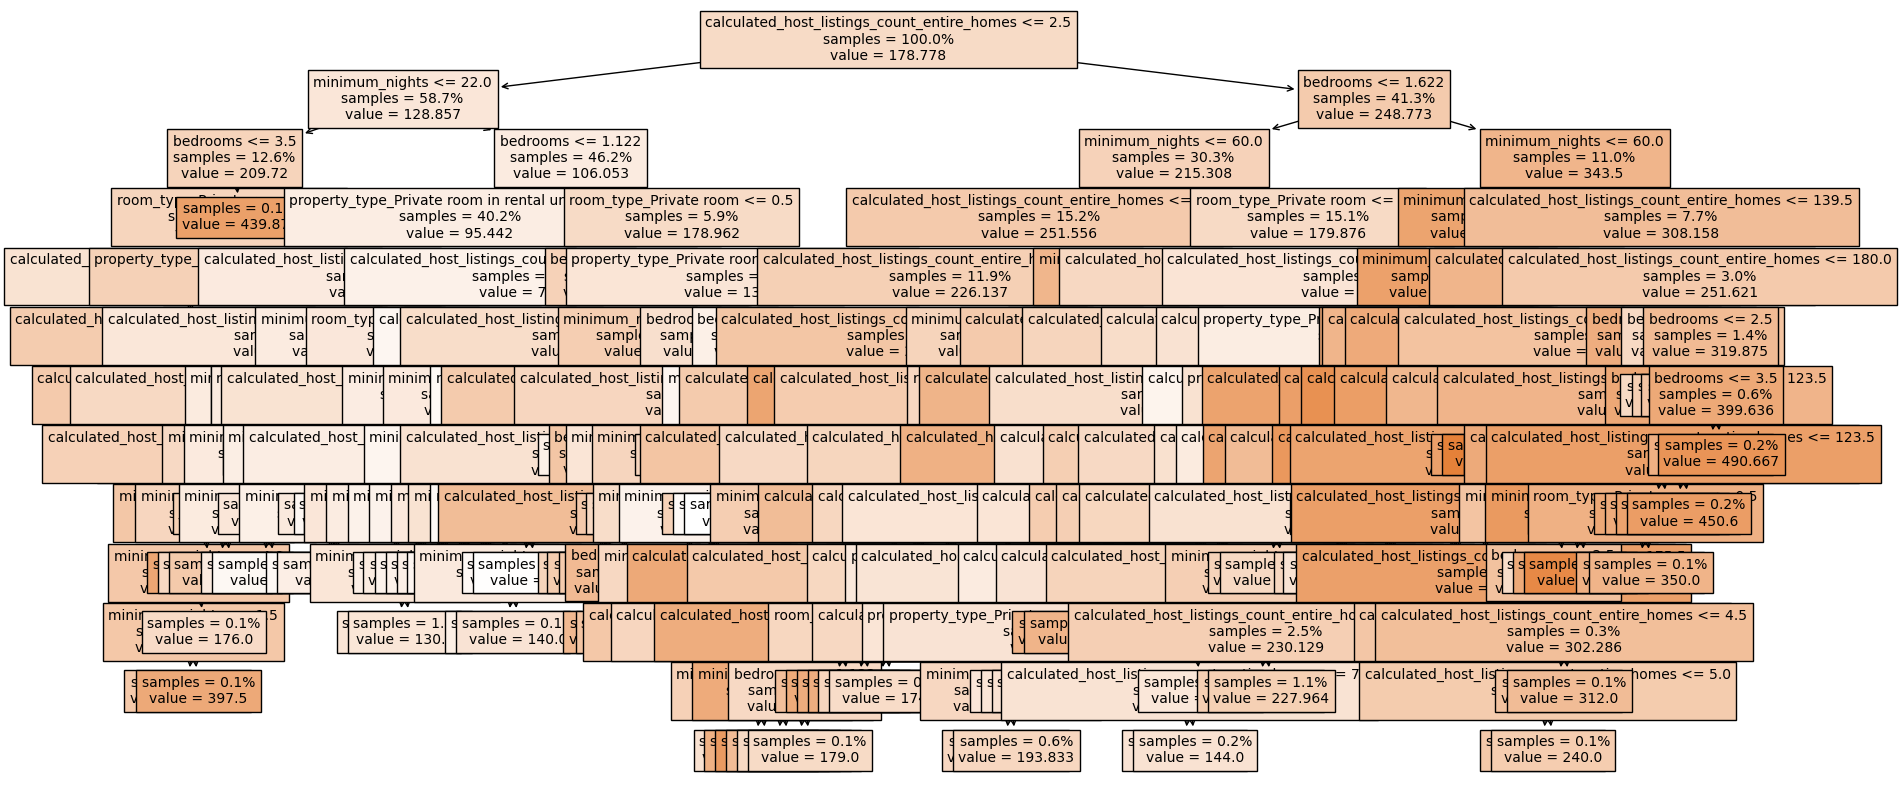

In [16]:
def plot_single_tree_from_rf(rf_model, feature_names):
    # Select a single decision tree from the random forest
    single_tree = rf_model.estimators_[0]

    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(20, 10))

    # Plot the decision tree
    plot_tree(single_tree, ax=ax, feature_names=feature_names, filled=True, fontsize=10, impurity=False, proportion=True)

    # Show the plot
    plt.show()

# Call the function with the appropriate arguments
plot_single_tree_from_rf(trained_rf_model, top_k_abs_correlated.index)

#### As seem from above, the tree is too saturated and dense making the data not readable and not presentable.

#### Solution: Make the tree more presentable by limiting its depth or pruning it. By setting the max_depth parameter when creating the random forest model, you can limit the maximum depth of each decision tree in the ensemble. This will simplify the tree visualization, making it easier to understand.

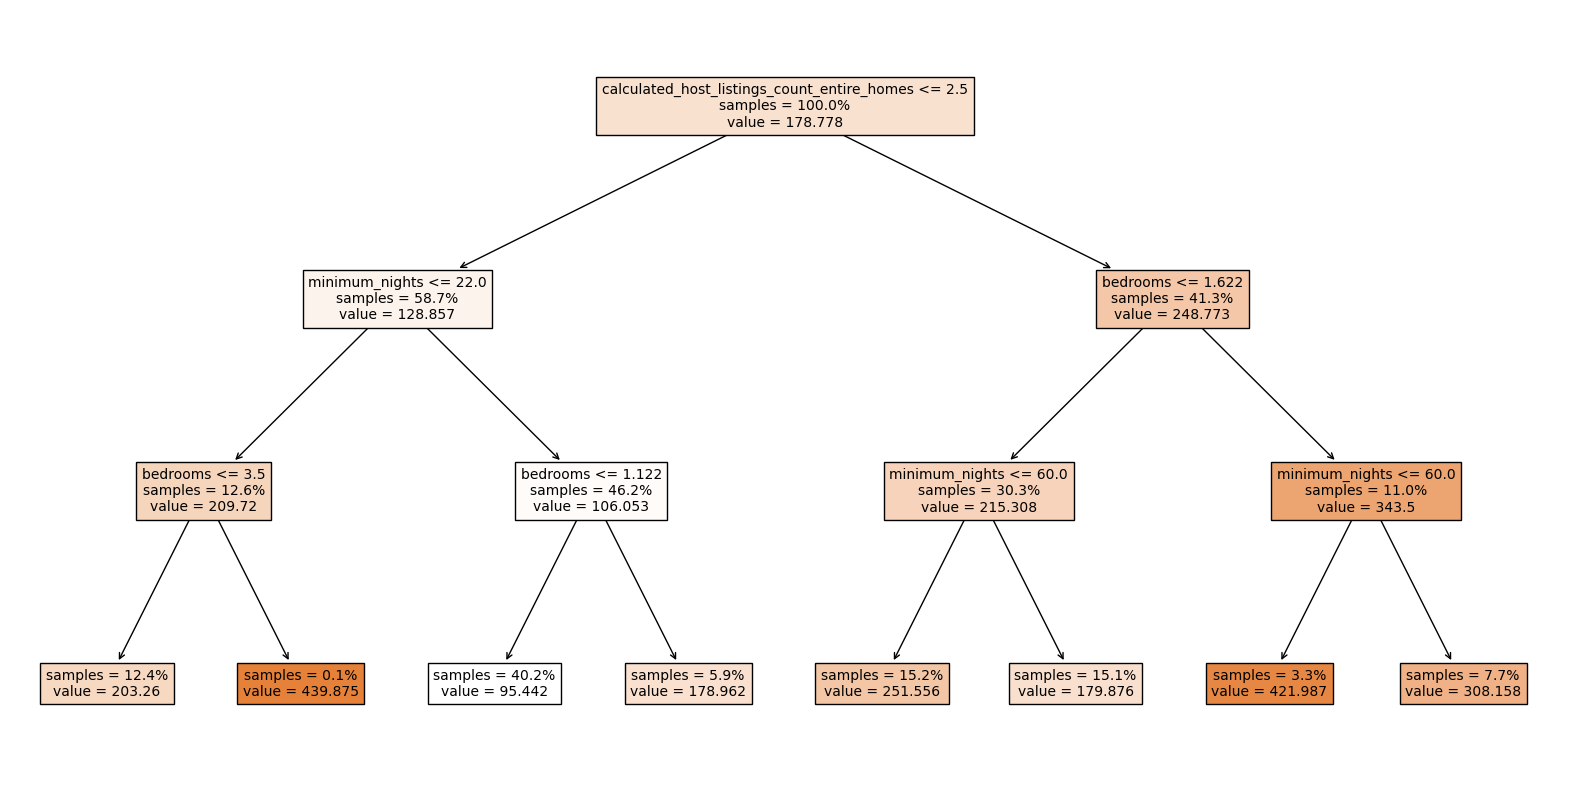

In [17]:
def plot_single_tree_from_limited_depth_rf(X_train_selected, y_train, feature_names, n_estimators=100, max_depth=3, random_state=42):
    # Create a random forest regression model with a maximum depth of 3
    rf_model_limited_depth = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)

    # Train the model using the training data with the selected features
    rf_model_limited_depth.fit(X_train_selected, y_train)

    # Select a single decision tree from the random forest
    single_tree_limited_depth = rf_model_limited_depth.estimators_[0]

    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(20, 10))

    # Plot the decision tree
    plot_tree(single_tree_limited_depth, ax=ax, feature_names=feature_names, filled=True, fontsize=10, impurity=False, proportion=True)

    # Show the plot
    plt.show()

plot_single_tree_from_limited_depth_rf(X_train_selected, y_train, top_k_abs_correlated.index)

#### For top 15

##### Filter and extract only top 15 variables to be used to predict the price (able to reuse the code from linear_regression.ipynb)

In [18]:
X_train_selected, X_test_selected, top_k_abs_correlated = select_top_k_abs_correlated(X_train, y_train, X_test, k=15)

Top 15 variables with the highest absolute correlation values:
 room_type_Private room                         0.442091
bedrooms                                       0.425693
calculated_host_listings_count_entire_homes    0.410485
property_type_Private room in rental unit      0.400065
minimum_nights                                 0.389756
maximum_minimum_nights                         0.389445
minimum_nights_avg_ntm                         0.386769
minimum_minimum_nights                         0.384322
host_listings_count                            0.347692
calculated_host_listings_count                 0.323658
host_total_listings_count                      0.316270
host_id                                        0.305003
property_type_Entire rental unit               0.288468
accommodates                                   0.284359
property_type_Entire serviced apartment        0.282429
dtype: float64


#### Create the model, predict the data and display the performance metrics

In [19]:
trained_rf_model, y_pred_rf = train_random_forest(X_train_selected, y_train, X_test_selected, y_test, n_estimators=100, random_state=42)

Performance metrics
Random Forest - Mean squared error: 4916.027420561626
Random Forest - R^2 score: 0.7017951769351406


##### Feature importance

In [20]:
print_rf_sorted_feature_importances(top_k_abs_correlated, trained_rf_model)

Feature importance
calculated_host_listings_count_entire_homes: 0.2835
host_id: 0.2151
accommodates: 0.1395
bedrooms: 0.0649
host_total_listings_count: 0.0636
calculated_host_listings_count: 0.0369
minimum_nights: 0.0365
maximum_minimum_nights: 0.0338
host_listings_count: 0.0309
room_type_Private room: 0.0265
minimum_minimum_nights: 0.0264
minimum_nights_avg_ntm: 0.0238
property_type_Entire rental unit: 0.0095
property_type_Private room in rental unit: 0.0049
property_type_Entire serviced apartment: 0.0041


##### Performance of model

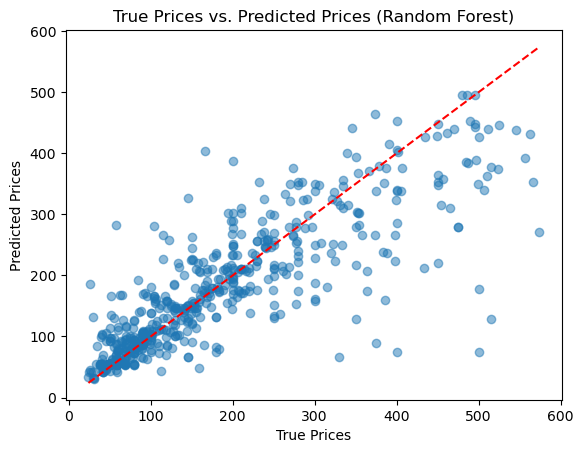

In [21]:
plot_true_vs_predicted_rf(y_test, y_pred_rf)

##### Model plot

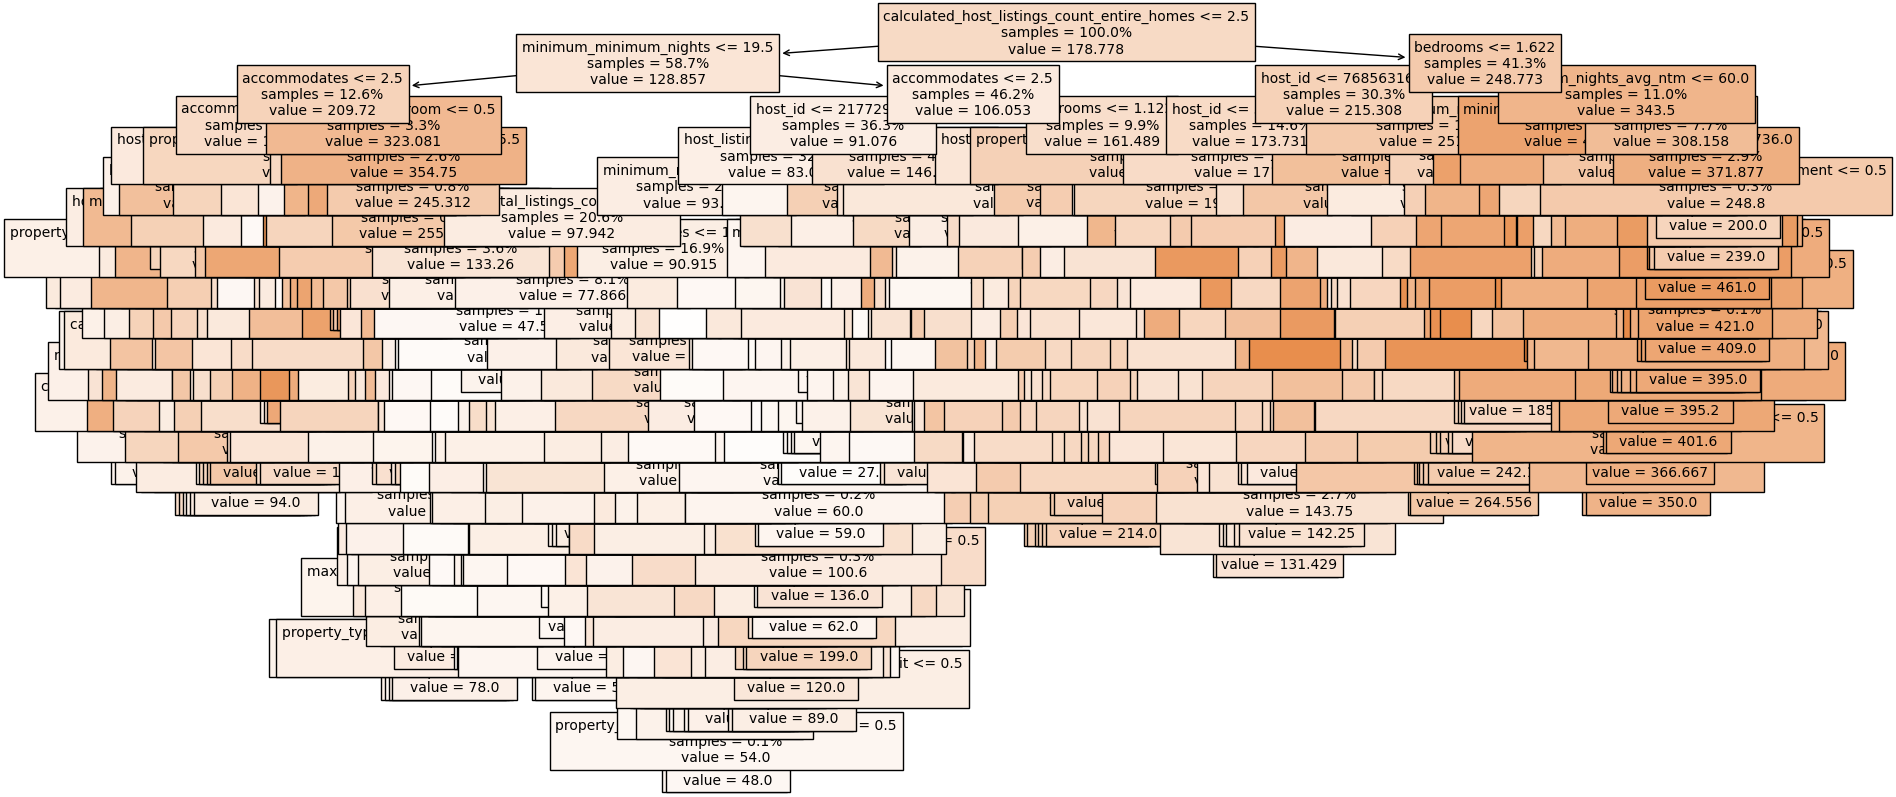

In [22]:
plot_single_tree_from_rf(trained_rf_model, top_k_abs_correlated.index)

##### Updated solution of model plot

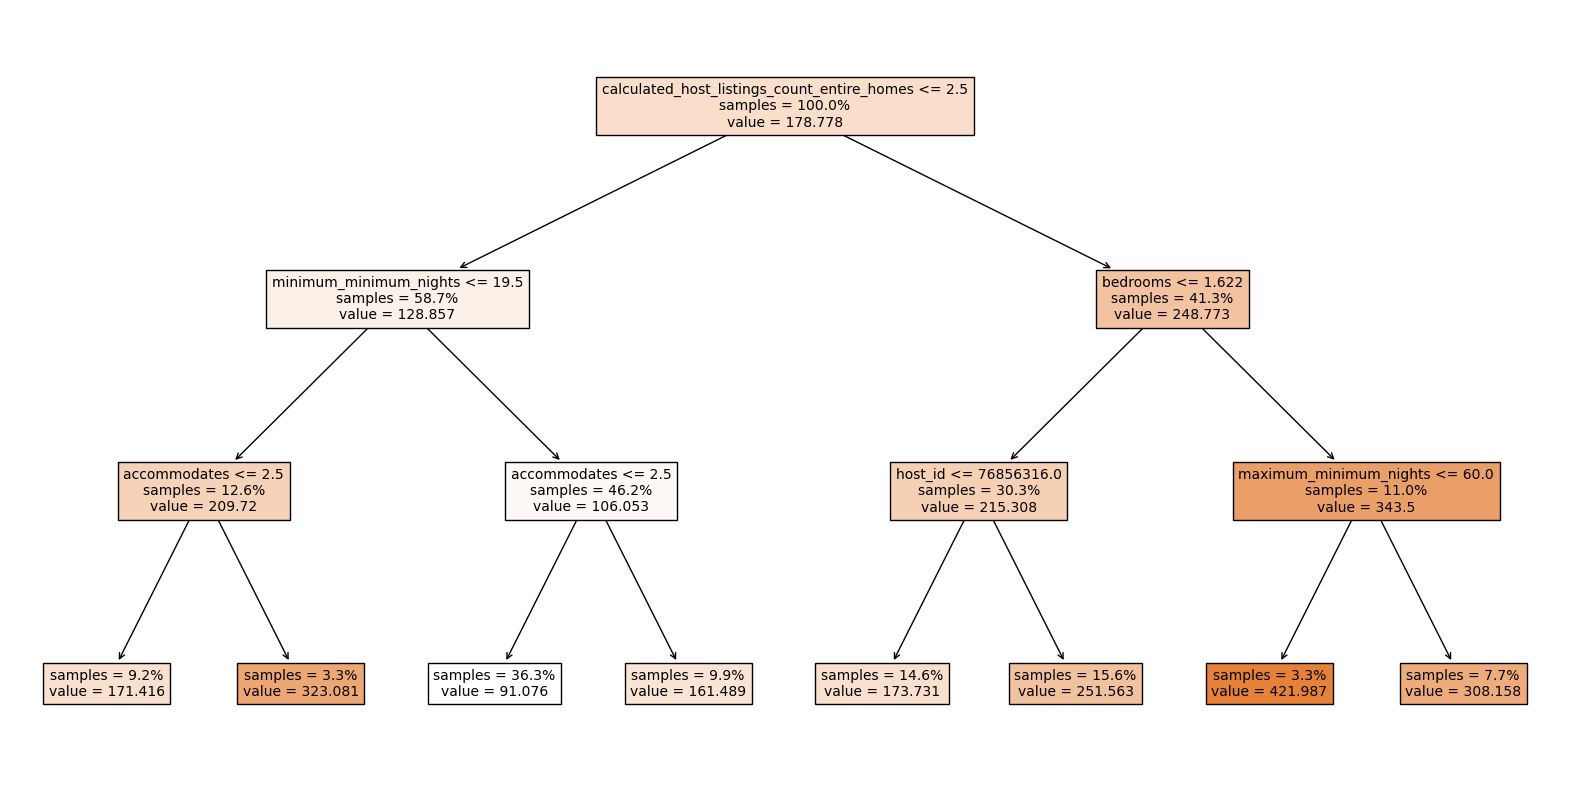

In [23]:
plot_single_tree_from_limited_depth_rf(X_train_selected, y_train, top_k_abs_correlated.index)

#### For top 25

##### Filter and extract only top 25 variables to be used to predict the price (able to reuse the code from linear_regression.ipynb)

In [24]:
X_train_selected, X_test_selected, top_k_abs_correlated = select_top_k_abs_correlated(X_train, y_train, X_test, k=25)

Top 25 variables with the highest absolute correlation values:
 room_type_Private room                          0.442091
bedrooms                                        0.425693
calculated_host_listings_count_entire_homes     0.410485
property_type_Private room in rental unit       0.400065
minimum_nights                                  0.389756
maximum_minimum_nights                          0.389445
minimum_nights_avg_ntm                          0.386769
minimum_minimum_nights                          0.384322
host_listings_count                             0.347692
calculated_host_listings_count                  0.323658
host_total_listings_count                       0.316270
host_id                                         0.305003
property_type_Entire rental unit                0.288468
accommodates                                    0.284359
property_type_Entire serviced apartment         0.282429
name_score                                      0.280922
id                      

##### Create the model, predict the data and display the performance metrics

In [25]:
trained_rf_model, y_pred_rf = train_random_forest(X_train_selected, y_train, X_test_selected, y_test, n_estimators=100, random_state=42)

Performance metrics
Random Forest - Mean squared error: 4229.627248161121
Random Forest - R^2 score: 0.7434320158808023


##### Feature importance

In [26]:
print_rf_sorted_feature_importances(top_k_abs_correlated, trained_rf_model)

Feature importance
calculated_host_listings_count_entire_homes: 0.2634
host_id: 0.1413
accommodates: 0.1019
latitude: 0.0906
bedrooms: 0.0557
amenities_count: 0.0478
id: 0.0395
host_total_listings_count: 0.0326
maximum_minimum_nights: 0.0317
minimum_nights: 0.0217
minimum_minimum_nights: 0.0214
minimum_nights_avg_ntm: 0.0189
calculated_host_listings_count_private_rooms: 0.0186
availability_60: 0.0184
availability_30: 0.0184
calculated_host_listings_count: 0.0155
host_acceptance_rate: 0.0150
host_listings_count: 0.0145
room_type_Private room: 0.0098
name_score: 0.0071
description_score: 0.0047
property_type_Entire rental unit: 0.0045
property_type_Private room in rental unit: 0.0031
property_type_Entire condo: 0.0025
property_type_Entire serviced apartment: 0.0014


##### Performance of model

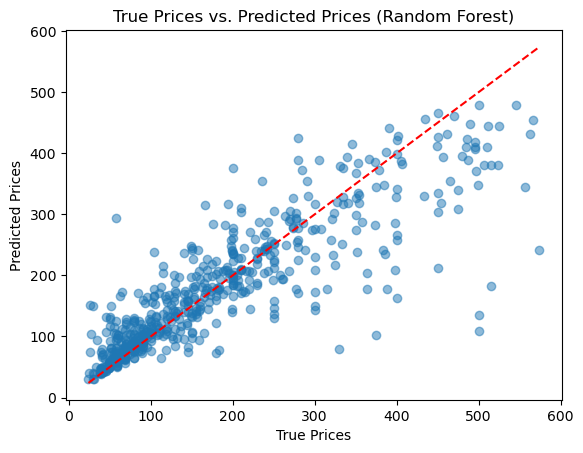

In [27]:
plot_true_vs_predicted_rf(y_test, y_pred_rf)

##### Model plot

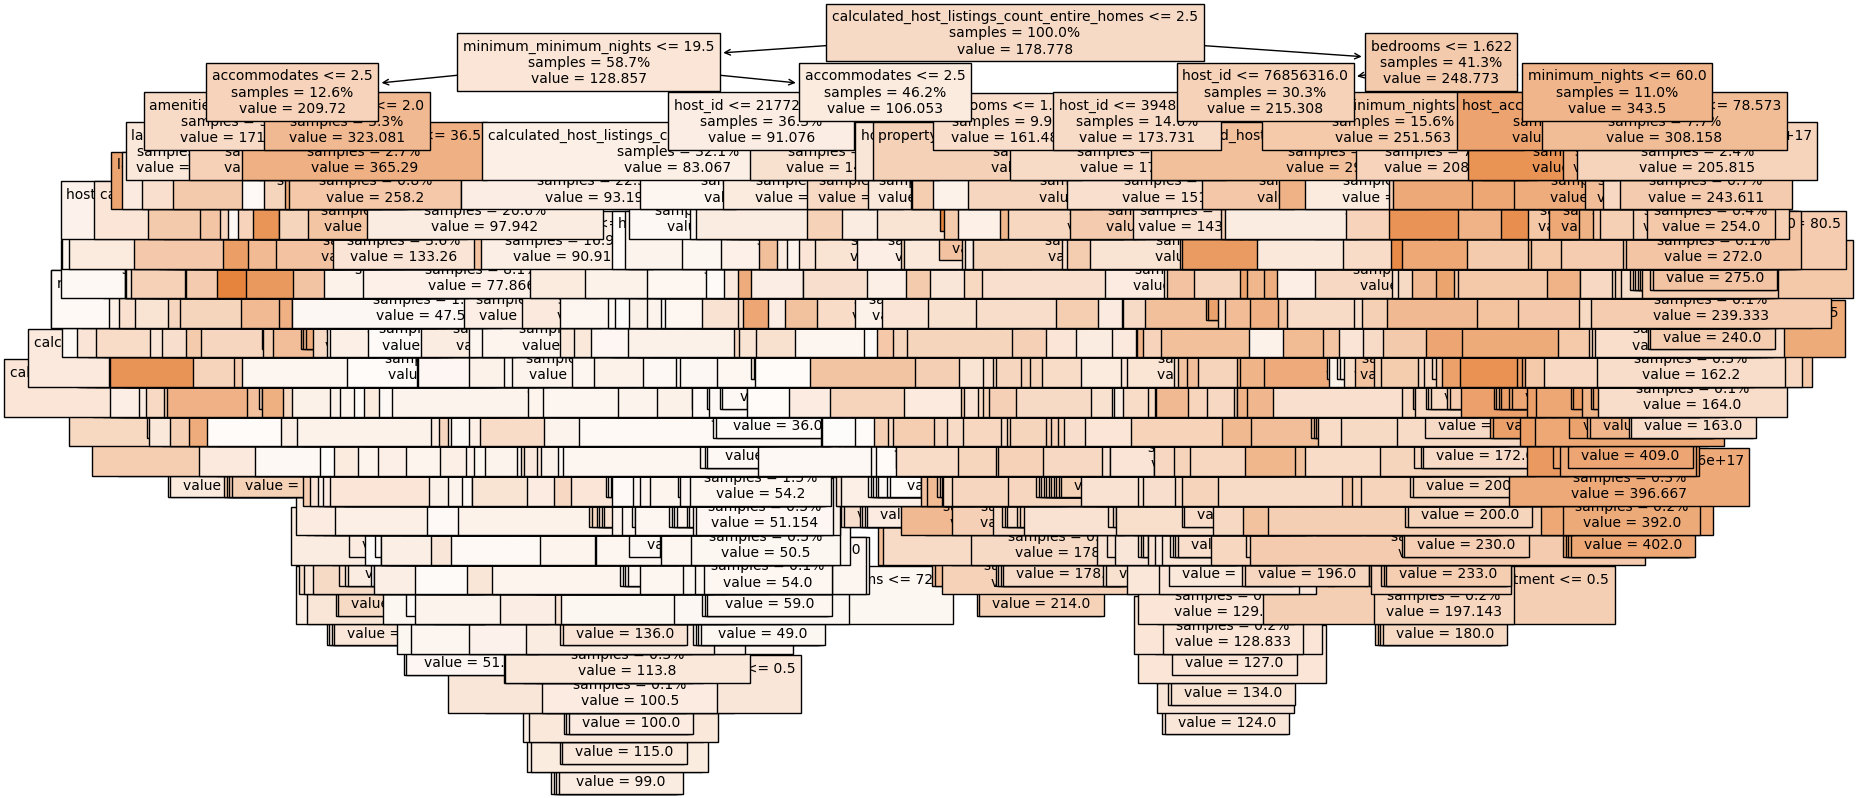

In [28]:
plot_single_tree_from_rf(trained_rf_model, top_k_abs_correlated.index)

##### Updated solution of model plot

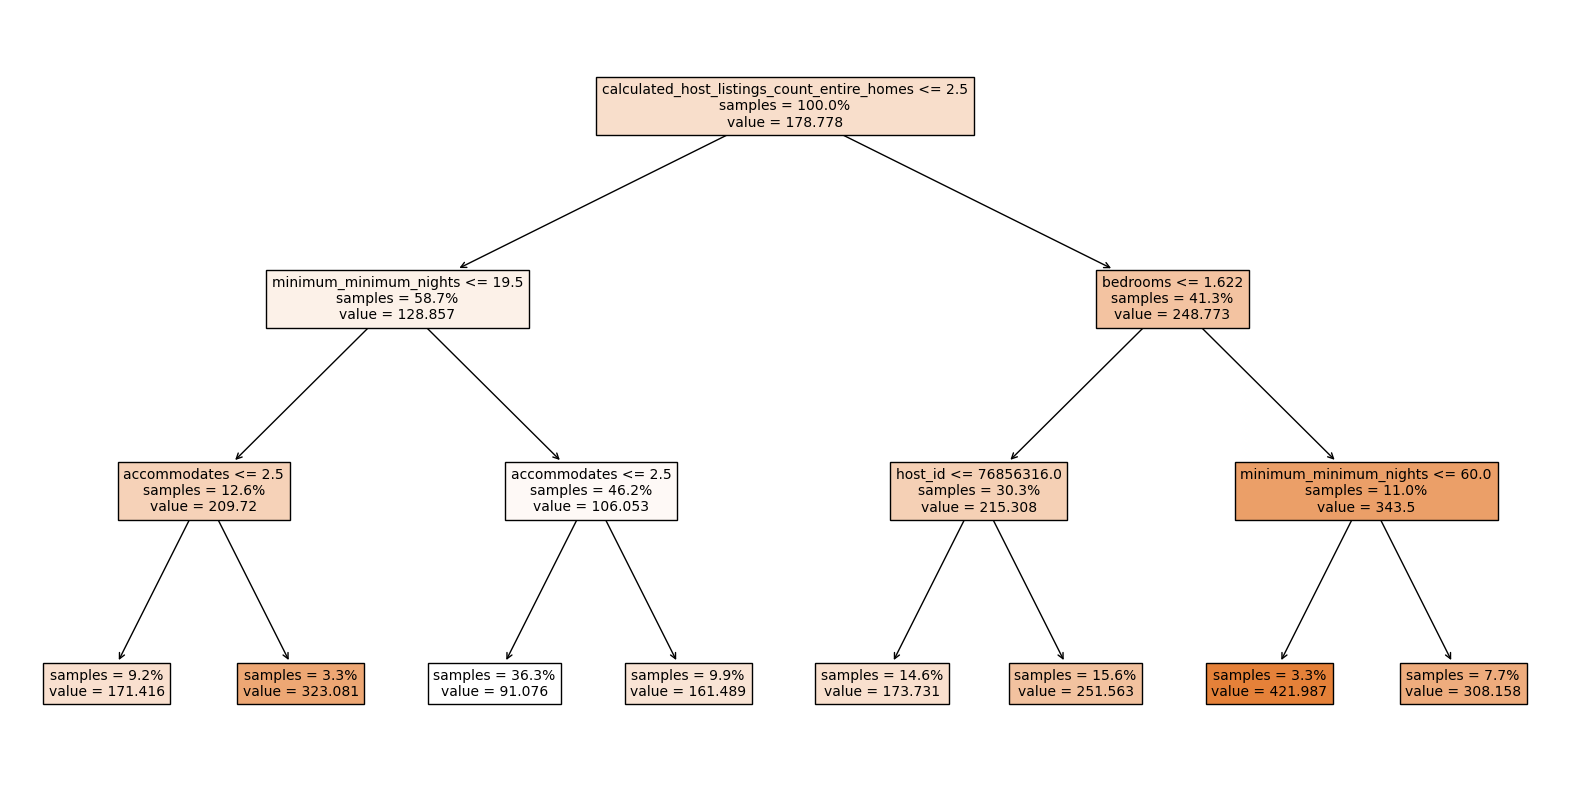

In [29]:
plot_single_tree_from_limited_depth_rf(X_train_selected, y_train, top_k_abs_correlated.index)